In [1]:
from rl_qoc import QuantumEnvironment, QiskitConfig, QEnvConfig, ExecutionConfig, StateTarget, ShadowReward, GateTarget, BenchmarkConfig
from qiskit.circuit import QuantumCircuit, ParameterVector, QuantumRegister
from qiskit.circuit.library import RXGate, UGate, RZXGate
from qiskit.quantum_info import Statevector, state_fidelity, DensityMatrix, random_statevector, Choi, Operator, SuperOp, SparsePauliOp, Pauli
from rl_qoc import PPOConfig, CustomPPO
from rl_qoc import RescaleAndClipAction

from gymnasium.spaces import Box
import numpy as np


c:\Users\Admin\.conda\envs\rl_qoc\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Admin\Documents\Python Scripts\Quantum_Optimal_Control\rl_qoc\helpers\__init__.py:9: UserWarning: pulse_utils is not available
  warnings.warn("pulse_utils is not available")


In [2]:
# simplified 1 qubit circuit of one parameter
def apply_parametrized_gate(qc: QuantumCircuit, params: ParameterVector, qr: QuantumRegister, *args, **kwargs):
    qc.ry(params[0], 0)

# 1 qubit parametrized state of one parameter
theta = np.pi/8 #generate a random target state; this is the goal we want to obtain
tgt_state = np.cos(theta/2) * Statevector.from_label('0') + np.sin(theta/2) * Statevector.from_label('1')

#params = np.array([[theta]])
params = np.array([[np.random.rand()*np.pi] for i in range(2)]) # for only one parameter in the circuit, over a few batches


def shadow_bound_state(error, observables, coeffs, failure_rate=0.01):
   
    M = len(observables)
    K = 2 * np.log(2 * M / failure_rate)
    shadow_norm = (
        lambda op: np.linalg.norm(
            op - np.trace(op) / 2 ** int(np.log2(op.shape[0])), ord=np.inf
        )
        ** 2
    )
    N = 34 * max(shadow_norm(observables[i]) * coeffs[i]**2 for i in range(len(observables))) / error ** 2
    
    return max(int(np.ceil(N.real * K)), 10000), int(K), M           #sometimes N = 0. A limit of 10000 is set to prevent this

In [ ]:
state_target = StateTarget(tgt_state)
backend_config = QiskitConfig(apply_parametrized_gate)
config = QEnvConfig(
    target = state_target,
    backend_config = backend_config,
    action_space = Box(low= 0, high = 2 * np.pi, shape=(1,)),
    execution_config = ExecutionConfig(batch_size = 20, sampling_paulis = 100, n_shots=1, seed=42),
    reward = "shadow",   # change
    benchmark_config = BenchmarkConfig(benchmark_cycle = 1)
)

Qenv = QuantumEnvironment(config)

In [4]:
agent_config = PPOConfig.from_yaml("agent_config.yaml")  # may need to specify entire path
rescaled_env = RescaleAndClipAction(Qenv, min_action=-1, max_action=1)
agent = CustomPPO(agent_config = agent_config, env=rescaled_env)


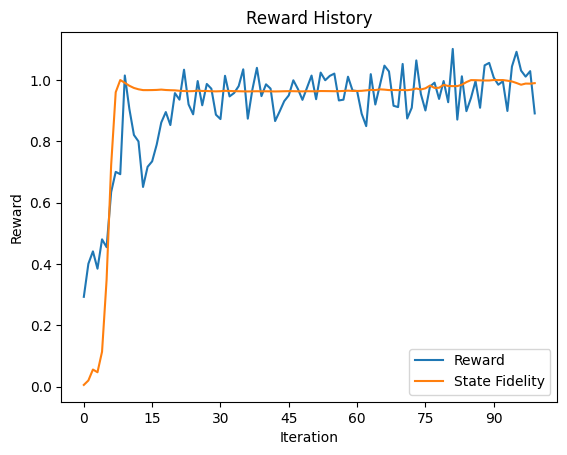

<Figure size 640x480 with 0 Axes>

In [ ]:
# training
from rl_qoc.agent import TrainFunctionSettings, TrainingConfig, TotalUpdates
total_update = TotalUpdates(100)
training_config = TrainingConfig(training_constraint=total_update)  #target_fidelities to be specified as a goal
function_settings = TrainFunctionSettings(plot_real_time=True)
result = agent.train(training_config=training_config, train_function_settings=function_settings)


In [7]:
# compare number of shots needed for each reward
# compare the times it takes to converge?
# play with agent parameters
Qenv.total_shots

[np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000),
 np.int64(2000

In [9]:
result.keys()

dict_keys(['avg_reward', 'fidelity_history', 'hardware_runtime', 'total_shots', 'total_updates', 'clipped_mean_action_0', 'mean_action_0', 'std_action_0', 'mean_action', 'std_action', 'clipped_mean_action'])